In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
import numpy as np
import dataset_utils
import importlib
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.preprocessing import StandardScaler

importlib.reload(dataset_utils)

<module 'dataset_utils' from '/home/fogliodicarta/Desktop/InsectClassification/dataset_utils.py'>

# Read dataset

In [2]:
species2genus = torch.load('tensor_dataset/species2genus.pt')
described_species_train = torch.load('tensor_dataset/described_species_labels_train.pt')
described_species_trainval = torch.load('tensor_dataset/described_species_labels_trainval.pt')
described_species_labels = described_species_train

In [3]:
expanded_train_dna_features = torch.load('dna_train_features.pt')
expanded_train_dna_labels = torch.load('dna_train_labels.pt')
image_train_features = torch.load('img_train_features.pt')
image_train_labels= torch.load('img_train_labels.pt')
assert((image_train_labels == expanded_train_dna_labels).all())

In [4]:
expanded_val_dna_features = torch.load('dna_val_features.pt')
expanded_val_dna_labels = torch.load('dna_val_labels.pt')
image_val_features = torch.load('img_val_features.pt')
image_val_labels = torch.load('img_val_labels.pt')
assert((image_val_labels == expanded_val_dna_labels).all())

In [5]:
expanded_test_dna_features = torch.load('dna_test_features.pt')
expanded_test_dna_labels = torch.load('dna_test_labels.pt')
image_test_features = torch.load('img_test_features.pt')
image_test_labels = torch.load('img_test_labels.pt')
assert((image_test_labels == expanded_test_dna_labels).all())
n_classes = 1050

In [6]:
torch.load('tensor_dataset/all_dnas.pt').mean()

tensor(0.1997, dtype=torch.float64)

In [7]:
expanded_train_dna_features.mean()

tensor(0.3692)

In [8]:
import scipy.io as io
using_matlab_dataset  = False
if using_matlab_dataset:
    dset = io.loadmat('matlab_dataset/insect_dataset.mat') 
    all_dna_features_cnn_original = dset['all_dna_features_cnn_original']
    all_image_features_resnet = dset['all_image_features_resnet']
    train_loc = np.squeeze(dset['train_loc']-1)
    val_seen_loc = np.squeeze(dset['val_seen_loc']-1)
    val_unseen_loc = np.squeeze(dset['val_unseen_loc']-1)
    test_seen_loc = np.squeeze(dset['test_seen_loc']-1)
    test_unseen_loc = np.squeeze(dset['test_unseen_loc']-1)
    expanded_train_dna_features = torch.tensor(all_dna_features_cnn_original[train_loc])
    expanded_val_dna_features = torch.tensor(all_dna_features_cnn_original[np.concatenate((val_seen_loc,val_unseen_loc))])
    expanded_test_dna_features = torch.tensor(all_dna_features_cnn_original[np.concatenate((test_seen_loc,test_unseen_loc))])
    
    image_train_features = torch.tensor(all_image_features_resnet[train_loc])
    image_val_features = torch.tensor(all_image_features_resnet[np.concatenate((val_seen_loc,val_unseen_loc))])
    image_test_features = torch.tensor(all_image_features_resnet[np.concatenate((test_seen_loc,test_unseen_loc))])
first_layer_size = image_train_features.shape[1] + expanded_train_dna_features.shape[1]


In [9]:
class InsectNet(torch.nn.Module):
    def __init__(self):
        super(InsectNet, self).__init__()
        self.dout = nn.Dropout(p=0.8)
        self.linear1 = nn.Linear(first_layer_size,372)
        self.act1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(372,n_classes)
        self.act2 = nn.LogSoftmax()
    def forward(self, x, temperature = 1):
        x = self.dout(x)
        x = self.linear1(x)
        x_genus = torch.nn.functional.log_softmax(x/temperature)#genus log probabilities
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x/temperature)#species log probabilities
        return x,x_genus

In [10]:
image_train_features.shape

torch.Size([13039, 2048])

In [11]:
image_train_labels.shape

torch.Size([13039])

In [12]:
expanded_train_dna_features.shape

torch.Size([13039, 3250])

In [13]:
expanded_train_dna_labels.shape


torch.Size([13039])

In [14]:
expanded_train_dna_features.mean()

tensor(0.3692)

# Choose if training on train or train+val and feature normalization

In [15]:
is_train_val = True # USE TRUE HERE IF ITS THE FINAL EVALUATION AND YOU WANT TO TRAIN ON TRAIN+VAL AND EVALUATE ON TEST
complete_train_features = torch.cat((expanded_train_dna_features,image_train_features),dim=1)
complete_val_features = torch.cat((expanded_val_dna_features,image_val_features),dim=1)
complete_test_features = torch.cat((expanded_test_dna_features,image_test_features),dim=1)
if is_train_val:
    complete_train_features = torch.cat((complete_train_features,complete_val_features),dim=0)
    complete_val_features = complete_test_features
    image_train_labels = torch.cat((image_train_labels,image_val_labels),dim=0)
    image_val_labels = image_test_labels
    described_species_labels = described_species_trainval

scaler = StandardScaler()
complete_train_features_scaled = scaler.fit_transform(complete_train_features)
complete_val_features_scaled = scaler.transform(complete_val_features)

In [16]:
complete_train_features_scaled.shape

(19994, 5298)

In [17]:
complete_val_features_scaled.mean()

-0.0022437350003675456

In [18]:
complete_val_features_scaled.shape

(12430, 5298)

In [19]:
from torch.utils.data import Dataset
class FeatureDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index].type(torch.LongTensor)
        
        #if self.transform:
        #    x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
        #    x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)
complete_train_features_scaled = torch.tensor(complete_train_features_scaled,dtype=torch.float)
complete_val_features_scaled = torch.tensor(complete_val_features_scaled,dtype=torch.float)

d_train = FeatureDataset(complete_train_features_scaled,image_train_labels)
d_val = FeatureDataset(complete_val_features_scaled,image_val_labels)

In [21]:
species2genus.min()
#species2genus.max()

tensor(0)

In [22]:
species2genus.shape

torch.Size([1050, 1])

In [23]:
complete_train_features_scaled.shape

torch.Size([19994, 5298])

# Fitting model

In [24]:
from torch.utils.data import DataLoader
batch_size = 1000
train_loader = DataLoader(d_train,shuffle=True,batch_size = batch_size)
val_loader = DataLoader(d_val,shuffle=True,batch_size = batch_size)
dataloaders = {'train':train_loader,'val':val_loader}
dataset_sizes = {'train':len(d_train.targets),'val':len(d_val.targets)}

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = InsectNet().to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=5)

In [26]:
from tqdm.notebook import tqdm
def fit(epochs,dataloaders,optimizer,model,start_idx=0):
    criterion = torch.nn.NLLLoss()
    if device == 'cuda:0':
        torch.cuda.empty_cache()
    
    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []
    for epoch in range(epochs):
        running_train_corrects = 0
        running_train_corrects_genus = 0
        for features,labels in tqdm(dataloaders['train']):
            model.train()
            genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
            features = features.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            
            optimizer.zero_grad()
            predicted_labels,predicted_genus_labels = model(features)
            
            train_loss = criterion(predicted_labels,labels)
            train_genus_loss = criterion(predicted_genus_labels,genus_labels)
            train_loss+=train_genus_loss
            train_loss.backward()
            optimizer.step()
            scheduler.step()
            
            _, preds = torch.max(predicted_labels, 1)
            _, genus_preds = torch.max(predicted_genus_labels, 1)
            running_train_corrects += torch.sum(preds == labels.data)
            running_train_corrects_genus += torch.sum(genus_preds == genus_labels)
        train_losses.append(train_loss)
        running_val_corrects = 0
        running_val_corrects_genus = 0
        for features,labels in tqdm(dataloaders['val']):
            
            model.eval()
            with torch.no_grad():
                genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
                features = features.to(device)
                labels = labels.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                
                predicted_labels,predicted_genus_labels = model(features)
                val_loss = criterion(predicted_labels,labels)
                
                _, preds = torch.max(predicted_labels, 1)
                _, genus_preds = torch.max(predicted_genus_labels, 1)
                running_val_corrects += torch.sum(preds == labels.data)
                running_val_corrects_genus += torch.sum(genus_preds == genus_labels)
        val_losses.append(val_loss)
        epoch_train_acc = running_train_corrects.double() / dataset_sizes['train']
        epoch_train_acc_genus = running_train_corrects_genus.double() / dataset_sizes['train']
        epoch_val_acc = running_val_corrects.double() / dataset_sizes['val']
        epoch_val_acc_genus = running_val_corrects_genus.double() / dataset_sizes['val']
        print("Epoch [{}/{}], train_loss: {:.4f},  train_score: {:.4f},val_loss: {:.4f},  val_score: {:.4f}, genus train_score{:.4f}, genus val_score{:.4f}".format(
            epoch+1, epochs, train_loss, epoch_train_acc,val_loss,epoch_val_acc,epoch_train_acc_genus,epoch_val_acc_genus))
    return train_losses

In [27]:

_ = fit(100,dataloaders,optimizer,model)

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_12734/2367995586.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
/tmp/ipykernel_12734/1170044867.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x_genus = torch.nn.functional.log_softmax(x/temperature)#genus log probabilities
/home/fogliodicarta/miniconda3/envs/insetti/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/100], train_loss: 6.2877,  train_score: 0.1840,val_loss: 7.0832,  val_score: 0.1382, genus train_score0.3965, genus val_score0.7400


/tmp/ipykernel_12734/2367995586.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/100], train_loss: 3.4469,  train_score: 0.4305,val_loss: 7.9291,  val_score: 0.2375, genus train_score0.8577, genus val_score0.8772


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/100], train_loss: 2.1685,  train_score: 0.6579,val_loss: 8.1527,  val_score: 0.2989, genus train_score0.9530, genus val_score0.8990


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/100], train_loss: 1.3969,  train_score: 0.7991,val_loss: 8.8059,  val_score: 0.3454, genus train_score0.9722, genus val_score0.9051


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/100], train_loss: 0.8505,  train_score: 0.9015,val_loss: 8.2937,  val_score: 0.3762, genus train_score0.9781, genus val_score0.9085


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/100], train_loss: 0.5442,  train_score: 0.9523,val_loss: 8.3278,  val_score: 0.3873, genus train_score0.9849, genus val_score0.9110


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/100], train_loss: 0.3050,  train_score: 0.9690,val_loss: 8.6755,  val_score: 0.3911, genus train_score0.9865, genus val_score0.9115


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/100], train_loss: 0.2779,  train_score: 0.9760,val_loss: 9.3384,  val_score: 0.3920, genus train_score0.9899, genus val_score0.9114


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/100], train_loss: 0.1312,  train_score: 0.9822,val_loss: 8.6359,  val_score: 0.3936, genus train_score0.9912, genus val_score0.9131


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/100], train_loss: 0.1234,  train_score: 0.9856,val_loss: 9.3465,  val_score: 0.3942, genus train_score0.9930, genus val_score0.9154


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/100], train_loss: 0.1034,  train_score: 0.9873,val_loss: 9.0345,  val_score: 0.3944, genus train_score0.9939, genus val_score0.9177


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/100], train_loss: 0.1006,  train_score: 0.9893,val_loss: 8.8611,  val_score: 0.3961, genus train_score0.9954, genus val_score0.9192


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/100], train_loss: 0.0757,  train_score: 0.9915,val_loss: 9.2684,  val_score: 0.3956, genus train_score0.9968, genus val_score0.9188


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/100], train_loss: 0.0880,  train_score: 0.9930,val_loss: 8.7725,  val_score: 0.3962, genus train_score0.9971, genus val_score0.9193


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/100], train_loss: 0.0589,  train_score: 0.9921,val_loss: 9.7707,  val_score: 0.3961, genus train_score0.9965, genus val_score0.9210


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/100], train_loss: 0.0866,  train_score: 0.9929,val_loss: 9.3113,  val_score: 0.3957, genus train_score0.9975, genus val_score0.9205


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/100], train_loss: 0.0647,  train_score: 0.9927,val_loss: 9.7429,  val_score: 0.3967, genus train_score0.9967, genus val_score0.9204


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/100], train_loss: 0.0522,  train_score: 0.9928,val_loss: 9.3002,  val_score: 0.3960, genus train_score0.9973, genus val_score0.9217


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/100], train_loss: 0.0785,  train_score: 0.9938,val_loss: 9.1541,  val_score: 0.3964, genus train_score0.9975, genus val_score0.9223


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/100], train_loss: 0.0423,  train_score: 0.9942,val_loss: 9.9377,  val_score: 0.3965, genus train_score0.9980, genus val_score0.9224


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21/100], train_loss: 0.0282,  train_score: 0.9955,val_loss: 8.9625,  val_score: 0.3967, genus train_score0.9982, genus val_score0.9220


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22/100], train_loss: 0.0306,  train_score: 0.9954,val_loss: 9.0565,  val_score: 0.3968, genus train_score0.9986, genus val_score0.9229


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23/100], train_loss: 0.0492,  train_score: 0.9951,val_loss: 9.8288,  val_score: 0.3970, genus train_score0.9987, genus val_score0.9241


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24/100], train_loss: 0.0303,  train_score: 0.9969,val_loss: 9.2485,  val_score: 0.3969, genus train_score0.9989, genus val_score0.9248


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25/100], train_loss: 0.0237,  train_score: 0.9966,val_loss: 9.2701,  val_score: 0.3971, genus train_score0.9981, genus val_score0.9245


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26/100], train_loss: 0.0349,  train_score: 0.9966,val_loss: 9.2575,  val_score: 0.3973, genus train_score0.9991, genus val_score0.9245


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27/100], train_loss: 0.0344,  train_score: 0.9951,val_loss: 9.7357,  val_score: 0.3969, genus train_score0.9990, genus val_score0.9252


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28/100], train_loss: 0.0202,  train_score: 0.9965,val_loss: 9.4860,  val_score: 0.3977, genus train_score0.9994, genus val_score0.9250


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29/100], train_loss: 0.0344,  train_score: 0.9969,val_loss: 9.2649,  val_score: 0.3977, genus train_score0.9991, genus val_score0.9250


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30/100], train_loss: 0.0210,  train_score: 0.9975,val_loss: 9.1889,  val_score: 0.3975, genus train_score0.9990, genus val_score0.9252


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [31/100], train_loss: 0.0185,  train_score: 0.9975,val_loss: 8.7521,  val_score: 0.3977, genus train_score0.9990, genus val_score0.9251


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [32/100], train_loss: 0.0213,  train_score: 0.9981,val_loss: 9.1540,  val_score: 0.3975, genus train_score0.9994, genus val_score0.9248


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [33/100], train_loss: 0.0194,  train_score: 0.9965,val_loss: 9.4644,  val_score: 0.3976, genus train_score0.9995, genus val_score0.9255


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [34/100], train_loss: 0.0218,  train_score: 0.9975,val_loss: 8.7988,  val_score: 0.3975, genus train_score0.9989, genus val_score0.9257


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [35/100], train_loss: 0.0168,  train_score: 0.9980,val_loss: 9.3293,  val_score: 0.3977, genus train_score0.9992, genus val_score0.9264


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [36/100], train_loss: 0.0227,  train_score: 0.9974,val_loss: 9.3274,  val_score: 0.3977, genus train_score0.9992, genus val_score0.9261


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [37/100], train_loss: 0.0193,  train_score: 0.9973,val_loss: 10.4546,  val_score: 0.3977, genus train_score0.9995, genus val_score0.9255


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [38/100], train_loss: 0.0217,  train_score: 0.9971,val_loss: 9.4916,  val_score: 0.3977, genus train_score0.9991, genus val_score0.9262


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [39/100], train_loss: 0.0124,  train_score: 0.9979,val_loss: 9.1970,  val_score: 0.3977, genus train_score0.9993, genus val_score0.9263


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [40/100], train_loss: 0.0160,  train_score: 0.9977,val_loss: 9.5806,  val_score: 0.3975, genus train_score0.9997, genus val_score0.9267


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [41/100], train_loss: 0.0117,  train_score: 0.9983,val_loss: 9.8060,  val_score: 0.3979, genus train_score0.9995, genus val_score0.9278


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [42/100], train_loss: 0.0115,  train_score: 0.9974,val_loss: 9.2562,  val_score: 0.3977, genus train_score0.9993, genus val_score0.9278


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [43/100], train_loss: 0.0126,  train_score: 0.9978,val_loss: 9.0234,  val_score: 0.3977, genus train_score0.9996, genus val_score0.9281


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [44/100], train_loss: 0.0142,  train_score: 0.9978,val_loss: 8.8871,  val_score: 0.3977, genus train_score0.9993, genus val_score0.9277


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [45/100], train_loss: 0.0146,  train_score: 0.9968,val_loss: 9.7754,  val_score: 0.3977, genus train_score0.9996, genus val_score0.9290


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [46/100], train_loss: 0.0176,  train_score: 0.9968,val_loss: 9.3575,  val_score: 0.3977, genus train_score0.9994, genus val_score0.9293


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [47/100], train_loss: 0.0145,  train_score: 0.9981,val_loss: 9.3594,  val_score: 0.3977, genus train_score0.9997, genus val_score0.9283


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [48/100], train_loss: 0.0105,  train_score: 0.9982,val_loss: 9.2086,  val_score: 0.3976, genus train_score0.9994, genus val_score0.9286


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [49/100], train_loss: 0.0109,  train_score: 0.9979,val_loss: 9.8496,  val_score: 0.3974, genus train_score0.9997, genus val_score0.9281


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [50/100], train_loss: 0.0125,  train_score: 0.9979,val_loss: 9.7811,  val_score: 0.3974, genus train_score0.9994, genus val_score0.9282


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [51/100], train_loss: 0.0137,  train_score: 0.9984,val_loss: 9.9583,  val_score: 0.3977, genus train_score0.9996, genus val_score0.9287


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [52/100], train_loss: 0.0119,  train_score: 0.9981,val_loss: 9.1577,  val_score: 0.3975, genus train_score0.9995, genus val_score0.9291


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [53/100], train_loss: 0.0143,  train_score: 0.9982,val_loss: 9.2037,  val_score: 0.3977, genus train_score0.9994, genus val_score0.9292


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [54/100], train_loss: 0.0123,  train_score: 0.9978,val_loss: 9.5770,  val_score: 0.3978, genus train_score0.9995, genus val_score0.9298


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [55/100], train_loss: 0.0092,  train_score: 0.9982,val_loss: 9.5269,  val_score: 0.3977, genus train_score0.9998, genus val_score0.9293


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [56/100], train_loss: 0.0081,  train_score: 0.9987,val_loss: 9.4891,  val_score: 0.3977, genus train_score0.9998, genus val_score0.9286


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [57/100], train_loss: 0.0100,  train_score: 0.9988,val_loss: 9.5012,  val_score: 0.3979, genus train_score0.9997, genus val_score0.9290


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [58/100], train_loss: 0.0108,  train_score: 0.9983,val_loss: 9.4258,  val_score: 0.3981, genus train_score0.9996, genus val_score0.9298


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [59/100], train_loss: 0.0110,  train_score: 0.9983,val_loss: 8.9121,  val_score: 0.3978, genus train_score0.9996, genus val_score0.9298


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [60/100], train_loss: 0.0108,  train_score: 0.9982,val_loss: 9.7015,  val_score: 0.3977, genus train_score0.9998, genus val_score0.9302


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [61/100], train_loss: 0.0084,  train_score: 0.9978,val_loss: 9.7669,  val_score: 0.3977, genus train_score0.9997, genus val_score0.9298


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [62/100], train_loss: 0.0083,  train_score: 0.9984,val_loss: 9.7338,  val_score: 0.3979, genus train_score0.9996, genus val_score0.9300


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [63/100], train_loss: 0.0054,  train_score: 0.9979,val_loss: 9.3048,  val_score: 0.3979, genus train_score0.9998, genus val_score0.9302


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [64/100], train_loss: 0.0057,  train_score: 0.9987,val_loss: 9.3752,  val_score: 0.3976, genus train_score0.9995, genus val_score0.9298


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [65/100], train_loss: 0.0107,  train_score: 0.9982,val_loss: 9.6970,  val_score: 0.3974, genus train_score0.9995, genus val_score0.9292


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [66/100], train_loss: 0.0070,  train_score: 0.9986,val_loss: 9.0238,  val_score: 0.3977, genus train_score0.9998, genus val_score0.9290


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [67/100], train_loss: 0.0081,  train_score: 0.9982,val_loss: 8.8693,  val_score: 0.3977, genus train_score0.9997, genus val_score0.9298


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [68/100], train_loss: 0.0096,  train_score: 0.9989,val_loss: 9.2982,  val_score: 0.3977, genus train_score0.9997, genus val_score0.9301


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [69/100], train_loss: 0.0140,  train_score: 0.9983,val_loss: 9.3744,  val_score: 0.3978, genus train_score0.9999, genus val_score0.9290


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [70/100], train_loss: 0.0197,  train_score: 0.9975,val_loss: 9.4766,  val_score: 0.3977, genus train_score0.9996, genus val_score0.9292


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [71/100], train_loss: 0.0082,  train_score: 0.9968,val_loss: 9.4958,  val_score: 0.3974, genus train_score0.9998, genus val_score0.9302


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [72/100], train_loss: 0.0092,  train_score: 0.9976,val_loss: 9.6648,  val_score: 0.3971, genus train_score0.9997, genus val_score0.9296


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [73/100], train_loss: 0.0080,  train_score: 0.9984,val_loss: 8.9198,  val_score: 0.3976, genus train_score0.9996, genus val_score0.9290


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [74/100], train_loss: 0.0453,  train_score: 0.9983,val_loss: 9.5153,  val_score: 0.3977, genus train_score0.9998, genus val_score0.9292


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [75/100], train_loss: 0.0139,  train_score: 0.9983,val_loss: 8.7678,  val_score: 0.3977, genus train_score0.9996, genus val_score0.9294


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [76/100], train_loss: 0.0091,  train_score: 0.9986,val_loss: 9.0434,  val_score: 0.3978, genus train_score0.9997, genus val_score0.9291


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [77/100], train_loss: 0.0086,  train_score: 0.9977,val_loss: 9.4250,  val_score: 0.3977, genus train_score0.9998, genus val_score0.9290


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [78/100], train_loss: 0.0103,  train_score: 0.9981,val_loss: 9.3110,  val_score: 0.3980, genus train_score0.9998, genus val_score0.9296


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [79/100], train_loss: 0.0090,  train_score: 0.9984,val_loss: 9.3767,  val_score: 0.3978, genus train_score0.9999, genus val_score0.9293


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [80/100], train_loss: 0.0200,  train_score: 0.9982,val_loss: 9.1039,  val_score: 0.3977, genus train_score0.9997, genus val_score0.9289


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [81/100], train_loss: 0.0049,  train_score: 0.9983,val_loss: 8.6554,  val_score: 0.3978, genus train_score0.9998, genus val_score0.9293


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [82/100], train_loss: 0.0044,  train_score: 0.9992,val_loss: 9.3140,  val_score: 0.3981, genus train_score0.9998, genus val_score0.9290


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [83/100], train_loss: 0.0036,  train_score: 0.9987,val_loss: 9.1890,  val_score: 0.3978, genus train_score0.9998, genus val_score0.9295


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [84/100], train_loss: 0.0080,  train_score: 0.9980,val_loss: 8.2851,  val_score: 0.3979, genus train_score0.9998, genus val_score0.9307


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [85/100], train_loss: 0.0037,  train_score: 0.9990,val_loss: 9.1008,  val_score: 0.3979, genus train_score0.9996, genus val_score0.9298


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [86/100], train_loss: 0.0106,  train_score: 0.9983,val_loss: 8.8343,  val_score: 0.3979, genus train_score0.9997, genus val_score0.9302


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [87/100], train_loss: 0.0159,  train_score: 0.9982,val_loss: 9.2151,  val_score: 0.3978, genus train_score0.9996, genus val_score0.9304


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [88/100], train_loss: 0.0051,  train_score: 0.9983,val_loss: 8.2929,  val_score: 0.3976, genus train_score0.9999, genus val_score0.9307


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [89/100], train_loss: 0.0045,  train_score: 0.9984,val_loss: 8.5167,  val_score: 0.3973, genus train_score1.0000, genus val_score0.9306


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [90/100], train_loss: 0.0033,  train_score: 0.9986,val_loss: 8.4112,  val_score: 0.3976, genus train_score0.9999, genus val_score0.9314


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [91/100], train_loss: 0.0057,  train_score: 0.9982,val_loss: 8.9484,  val_score: 0.3977, genus train_score0.9999, genus val_score0.9311


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [92/100], train_loss: 0.0053,  train_score: 0.9982,val_loss: 8.9700,  val_score: 0.3976, genus train_score0.9997, genus val_score0.9311


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [93/100], train_loss: 0.0077,  train_score: 0.9982,val_loss: 9.1250,  val_score: 0.3979, genus train_score0.9997, genus val_score0.9314


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [94/100], train_loss: 0.0078,  train_score: 0.9984,val_loss: 9.0140,  val_score: 0.3979, genus train_score0.9998, genus val_score0.9315


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [95/100], train_loss: 0.0067,  train_score: 0.9973,val_loss: 8.7910,  val_score: 0.3981, genus train_score0.9997, genus val_score0.9303


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [96/100], train_loss: 0.0063,  train_score: 0.9979,val_loss: 8.6378,  val_score: 0.3980, genus train_score0.9999, genus val_score0.9297


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [97/100], train_loss: 0.0122,  train_score: 0.9981,val_loss: 8.9605,  val_score: 0.3982, genus train_score0.9997, genus val_score0.9300


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [98/100], train_loss: 0.0094,  train_score: 0.9980,val_loss: 8.3128,  val_score: 0.3977, genus train_score0.9997, genus val_score0.9299


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [99/100], train_loss: 0.0078,  train_score: 0.9986,val_loss: 8.5317,  val_score: 0.3979, genus train_score0.9998, genus val_score0.9301


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [100/100], train_loss: 0.0042,  train_score: 0.9980,val_loss: 8.5369,  val_score: 0.3978, genus train_score0.9995, genus val_score0.9309


# Estrazione features unseen dataset .mat

In [28]:
import scipy.io as io
from sklearn.model_selection import train_test_split
data = io.loadmat('get_unseen_fresh_samples/unseen_insect_dataset.mat')
all_image_features = data['all_image_features_gan']
all_dna_features = data['all_dna_features_cnn_new']
all_genus_labels = np.squeeze(data['all_genus_labels'])-1
X = np.concatenate((all_image_features,all_dna_features),axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, all_genus_labels, test_size=0.50, random_state=42)



In [29]:
all_genus_labels.min()

0

In [30]:
print(data['all_dna_features_cnn_new'].mean())
print(expanded_train_dna_features.mean())
print(expanded_val_dna_features.mean())
print(expanded_test_dna_features.mean())

0.3596095
tensor(0.3692)
tensor(0.3713)
tensor(0.3715)


In [31]:
print(data['all_dna_features_cnn_new'].std())
print(expanded_train_dna_features.std())
print(expanded_val_dna_features.std())
print(expanded_test_dna_features.std())

1.1701347
tensor(1.1705)
tensor(1.1715)
tensor(1.1716)


In [32]:
y_test

array([ 30,  95, 199, ...,  25, 288, 285])

In [33]:
all_image_features.mean()

0.01038311

In [34]:
complete_train_features = X_train
complete_val_features = X_test
image_train_labels = y_train
image_val_labels = y_test
#described_species_labels = described_species_trainval

scaler = StandardScaler()
complete_train_features_scaled = scaler.fit_transform(complete_train_features)
complete_val_features_scaled = scaler.transform(complete_val_features)

from torch.utils.data import Dataset
class FeatureDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index].type(torch.LongTensor)
        
        #if self.transform:
        #    x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
        #    x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)
complete_train_features_scaled = torch.tensor(complete_train_features_scaled,dtype=torch.float)
complete_val_features_scaled = torch.tensor(complete_val_features_scaled,dtype=torch.float)

d_train = FeatureDataset(complete_train_features_scaled,image_train_labels)
d_val = FeatureDataset(complete_val_features_scaled,image_val_labels)


In [35]:
d_train.data.shape[0]+d_val.data.shape[0]

40050

In [36]:
complete_val_features_scaled.mean()

tensor(-0.0002)

In [37]:
image_val_labels

array([ 30,  95, 199, ...,  25, 288, 285])

In [38]:
image_train_labels

array([ 95, 269,  95, ...,  68, 158, 254])

In [91]:
# try dataset with forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(complete_train_features_scaled, y_train)
train_predicted_labels = clf.predict(complete_train_features_scaled)
print(f"Training genus accuracy:{np.count_nonzero(train_predicted_labels==y_train)/len(y_train)}")
val_predicted_labels= clf.predict(complete_val_features_scaled)
print(f"Validation genus accuracy:{np.count_nonzero(val_predicted_labels==y_test)/len(y_test)}")

Training genus accuracy:0.9997503121098626
Validation genus accuracy:0.9139575530586767


In [100]:
val_predicted_labels= clf.predict(complete_val_features_scaled)
print(f"Validation genus accuracy:{np.count_nonzero(val_predicted_labels==species2genus[image_val_labels.long()])/len(image_val_labels)}")

Validation genus accuracy:0.0


In [38]:
val_predicted_labels

NameError: name 'val_predicted_labels' is not defined

tensor([[234],
        [234],
        [235],
        ...,
        [ 44],
        [ 44],
        [ 44]])

In [39]:
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    val_predicted_probs,val_predicted_probs_genus = (model(d_val.data.cuda(),temperature=1))
    val_predicted_probs = torch.exp(val_predicted_probs)
    val_predicted_probs_genus = torch.exp(val_predicted_probs_genus)
val_predicted_probs = val_predicted_probs.cpu()
val_predicted_probs_genus = val_predicted_probs_genus.cpu()

/tmp/ipykernel_12734/1170044867.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x_genus = torch.nn.functional.log_softmax(x/temperature)#genus log probabilities
/home/fogliodicarta/miniconda3/envs/insetti/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [40]:
val_predicted_labels = val_predicted_probs.argmax(axis=1)
val_predicted_labels_genus = val_predicted_probs_genus.argmax(axis=1)
image_val_labels = torch.tensor(image_val_labels).type(torch.LongTensor)

In [41]:
val_predicted_probs_genus[0].argmax()

tensor(230)

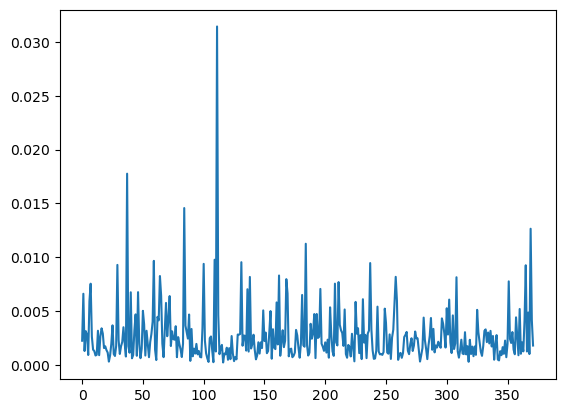

In [42]:
#example of output probabilities for undescribed insect
plt.plot(val_predicted_probs_genus[-1].cpu())
#plt.savefig("peaks10.png")

In [43]:
image_val_labels

tensor([ 30,  95, 199,  ...,  25, 288, 285])

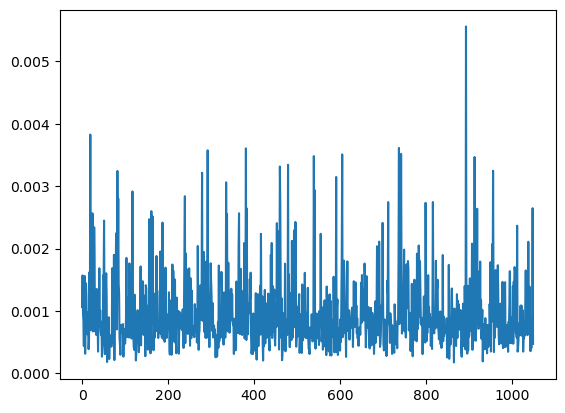

In [44]:
plt.plot(val_predicted_probs[1].cpu())


In [45]:
val_predicted_probs[1].topk(2)

torch.return_types.topk(
values=tensor([0.0056, 0.0038]),
indices=tensor([893,  19]))

In [46]:
val_predicted_probs_genus[1].topk(2)

torch.return_types.topk(
values=tensor([0.0470, 0.0308]),
indices=tensor([204, 329]))

In [47]:
species2genus[699]

tensor([287])

In [48]:
[x for x in range(len(species2genus)) if species2genus[x]==287]

[699]

In [49]:
species2genus

tensor([[234],
        [234],
        [235],
        ...,
        [ 44],
        [ 44],
        [311]])

In [50]:
val_predicted_labels

tensor([ 461,  893, 1035,  ...,  795,  243,  359])

In [51]:
val_predicted_labels_genus

tensor([230, 204, 235,  ..., 346, 279, 111])

In [52]:
y_test

array([ 30,  95, 199, ...,  25, 288, 285])

# top2 method to choose either genus or species as output

In [46]:
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
thresholds = []
possible_thresholds = [x / 10000 for x in range(0, 10000, 1000)]
for t in possible_thresholds:
    thresholds.append(t)
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(image_val_labels)):
        label_best_specie = val_predicted_labels[i]
       
        #assert val_predicted_labels[i]==val_predicted_probs[i].argmax(), f"{val_predicted_labels[i]}=={val_predicted_probs[i].argmax()}"
        genus_of_best_species = species2genus[label_best_specie.item()]

        top2 = torch.tensor(val_predicted_probs[i]).topk(2)#ATTENZIONE QUA E' DIVERSO
        #print(top2)
        if  False and (top2.values[0]-top2.values[1]) >t*top2.values[0]:#species 
            print(f"threshold:{t}")
            n_undescribed_samples+=1
        else:#genus
            #print(f"genus:{t}")

            n_undescribed_samples+=1
            #if genus_of_best_species == species2genus[image_val_labels[i]]:#guessed genus is correct
            #ATTENZIONE QUA E' DIVERSO
            print(f"bestgenus{genus_of_best_species.item()},predicted:{val_predicted_labels_genus[i]},real{image_val_labels[i]}")
            if val_predicted_labels_genus[i].item() == image_val_labels[i].item():#guessed genus is correct
                #n_correct_described_samples+=1
                n_correct_genus+=1
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples) # TPR = recall = sensitivity
    #fprs.append(1-n_correct_described_samples/n_described_samples) # 1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    #correct_species_rate.append(n_correct_species/n_described_samples)

/tmp/ipykernel_9140/3344680774.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top2 = torch.tensor(val_predicted_probs[i]).topk(2)#ATTENZIONE QUA E' DIVERSO


bestgenus235,predicted:34,real30
bestgenus287,predicted:4,real95
bestgenus58,predicted:113,real199
bestgenus123,predicted:176,real365
bestgenus291,predicted:277,real136
bestgenus198,predicted:100,real136
bestgenus263,predicted:61,real8
bestgenus27,predicted:209,real65
bestgenus120,predicted:262,real326
bestgenus118,predicted:251,real68
bestgenus176,predicted:143,real230
bestgenus157,predicted:280,real8
bestgenus95,predicted:150,real298
bestgenus300,predicted:302,real352
bestgenus54,predicted:292,real318
bestgenus118,predicted:251,real68
bestgenus136,predicted:240,real136
bestgenus7,predicted:106,real282
bestgenus187,predicted:58,real93
bestgenus364,predicted:201,real25
bestgenus296,predicted:118,real26
bestgenus157,predicted:181,real289
bestgenus198,predicted:271,real21
bestgenus54,predicted:29,real118
bestgenus58,predicted:250,real311
bestgenus176,predicted:194,real354
bestgenus14,predicted:97,real26
bestgenus268,predicted:255,real127
bestgenus58,predicted:53,real26
bestgenus214,predi

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



bestgenus168,predicted:308,real288
bestgenus95,predicted:143,real67
bestgenus193,predicted:4,real252
bestgenus58,predicted:344,real279
bestgenus180,predicted:170,real19
bestgenus7,predicted:193,real66
bestgenus28,predicted:70,real301
bestgenus20,predicted:53,real213
bestgenus162,predicted:302,real67
bestgenus274,predicted:68,real204
bestgenus54,predicted:297,real213
bestgenus110,predicted:110,real213
bestgenus58,predicted:363,real254
bestgenus268,predicted:365,real204
bestgenus12,predicted:12,real194
bestgenus143,predicted:265,real352
bestgenus95,predicted:363,real269
bestgenus143,predicted:158,real288
bestgenus71,predicted:58,real318
bestgenus97,predicted:289,real50
bestgenus331,predicted:366,real321
bestgenus201,predicted:330,real26
bestgenus268,predicted:186,real8
bestgenus3,predicted:133,real285
bestgenus17,predicted:60,real311
bestgenus302,predicted:18,real289
bestgenus58,predicted:340,real265
bestgenus110,predicted:54,real10
bestgenus323,predicted:156,real150
bestgenus268,predict

In [47]:
for index in range(0,len(correct_genus_rate),1):
    print(index)
    print(correct_genus_rate[index])
    #print(correct_species_rate[index])
    print('\n\n')

0
0.001947565543071161



1
0.001947565543071161



2
0.001947565543071161



3
0.001947565543071161



4
0.001947565543071161



5
0.001947565543071161



6
0.001947565543071161



7
0.001947565543071161



8
0.001947565543071161



9
0.001947565543071161





In [70]:
thresholds

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

Best harmonic mean 0.0006568953483598145
Best threshold 0.1


IndexError: list index out of range

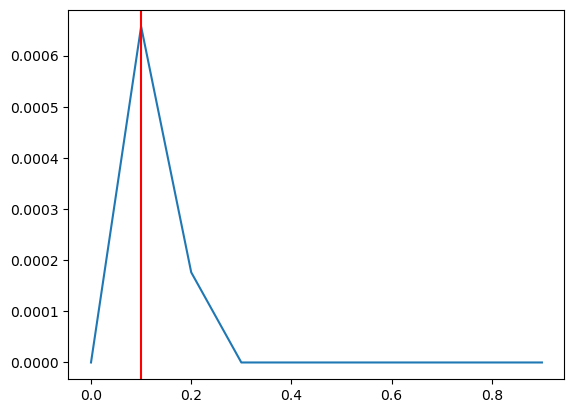

In [54]:
numerator = [2*a*b for a,b in zip(correct_genus_rate,correct_species_rate)]
denominator = [a+b for a,b in zip(correct_genus_rate,correct_species_rate)]
harmonic_mean = [a/b for a,b in zip(numerator,denominator)]
plt.plot(thresholds,harmonic_mean)
print("Best harmonic mean",max(harmonic_mean))
print("Best threshold",thresholds[harmonic_mean.index(max(harmonic_mean))])
plt.axvline(x=thresholds[harmonic_mean.index(max(harmonic_mean))],c='red',label="optimal threshold")
plt.axvline(x=thresholds[297],c='purple',label="threshold found in validation")
plt.title("Harmonic mean of species and genus correct rate")
plt.xlabel("threshold")
plt.ylabel("Harmonic mean")
plt.legend()
#plt.savefig("testoldfeatures.png")

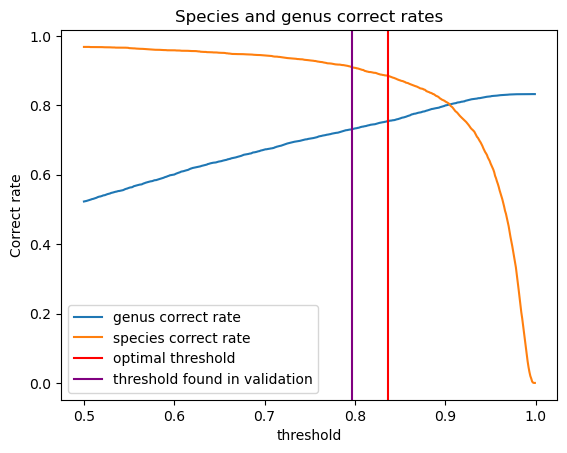

In [253]:
plt.plot(thresholds,correct_genus_rate[:],label="genus correct rate")
plt.plot(thresholds,correct_species_rate[:],label="species correct rate")
plt.axvline(x=thresholds[harmonic_mean.index(max(harmonic_mean))],c='red',label="optimal threshold")
plt.axvline(x=thresholds[297],c='purple',label="threshold found in validation")
plt.title("Species and genus correct rates")
plt.xlabel("threshold")
plt.ylabel("Correct rate")
plt.legend()
#plt.savefig("testoldfeaturesCR.png")

In [256]:
correct_genus_rate[index_of_threshold]

0.7313172043010753

In [257]:
correct_species_rate[index_of_threshold]

0.9094188376753507

In [258]:
harmonic_mean[index_of_threshold]

0.8107015691644405

In [259]:
#np.save("correct_rates/oldTestCGR.npy",correct_genus_rate)
#np.save("correct_rates/oldTestCSR.npy",correct_species_rate)

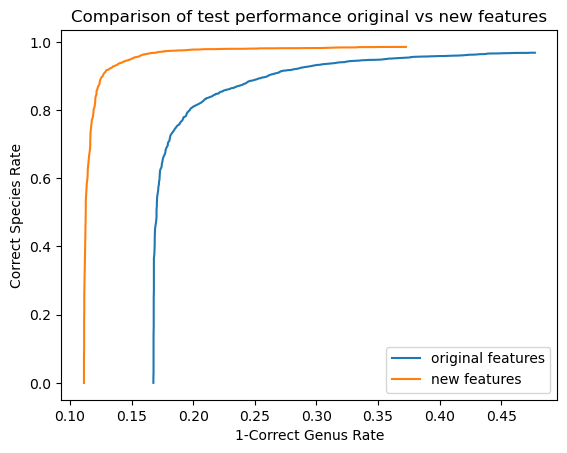

In [268]:
plt.plot(1-np.load("correct_rates/oldTestCGR.npy"),np.load("correct_rates/oldTestCSR.npy"),label='original features')
plt.plot(1-np.load("correct_rates/ourTestCGR.npy"),np.load("correct_rates/ourTestCSR.npy"),label="new features")
plt.title("Comparison of test performance original vs new features")
plt.xlabel("1-Correct Genus Rate")
plt.ylabel("Correct Species Rate")

plt.legend()
plt.savefig("test_comparison.png")

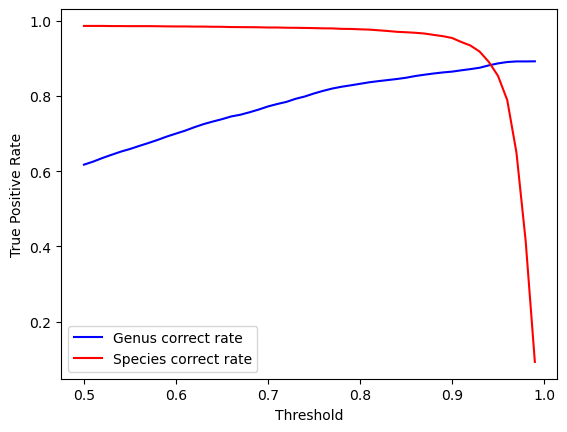

In [208]:
plt.plot(thresholds[-100:], correct_genus_rate[-100:], "-b", label="Genus correct rate")
plt.plot(thresholds[-100:], correct_species_rate[-100:], "-r", label="Species correct rate")

plt.xlabel("Threshold")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("GenusSpeciesCorrectRate.png")

In [22]:
species2genus[image_train_labels.long()][0]

tensor([234])

In [26]:
train_predicted_labels.shape

(19994,)

In [64]:
species2genus = species2genus.squeeze().numpy()

In [65]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(image_train_features, species2genus[image_train_labels.long()])
train_predicted_labels = clf.predict(image_train_features)
print(f"Training genus accuracy:{np.count_nonzero(train_predicted_labels==species2genus[image_train_labels.long()])/len(image_train_labels)}")
val_predicted_labels= clf.predict(image_val_features)
print(f"Validation genus accuracy:{np.count_nonzero(val_predicted_labels==species2genus[image_val_labels.long()])/len(image_val_labels)}")

Training genus accuracy:0.9991563770227778
Validation genus accuracy:0.608195542774982


In [63]:
train_predicted_labels

array([234, 234, 234, ..., 311, 311, 311])

In [66]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_image_features)


In [68]:
new_val_predicted_labels= clf.predict(all_image_features)
print(f"Validation genus accuracy:{np.count_nonzero(new_val_predicted_labels==all_genus_labels)/len(all_genus_labels)}")

Validation genus accuracy:0.07018726591760299


In [41]:
complete_train_features_scaled.mean()

-4.1491620252380696e-18

In [44]:
X_scaled.mean()

-3.1008757e-10

In [48]:
import pickle
with open('get_unseen_fresh_samples/genusname2genuslabel.pickle', 'rb') as handle:
    genusname2genuslabel = pickle.load(handle)

In [49]:
genusname2genuslabel

{'Abax': 234,
 'Acleris': 235,
 'Acordulecera': 231,
 'Acrolophus': 232,
 'Acronicta': 233,
 'Adalia': 236,
 'Adelpha': 157,
 'Adrastus': 161,
 'Aedes': 160,
 'Agabus': 158,
 'Agonum': 159,
 'Agriophara': 175,
 'Agriotes': 174,
 'Agrotis': 37,
 'Agrypnus': 40,
 'Aleochara': 42,
 'Aloconota': 38,
 'Alosterna': 41,
 'Amara': 39,
 'Amaxia': 138,
 'Ametastegia': 140,
 'Amischa': 142,
 'Ammophila': 141,
 'Amorbia': 139,
 'Ampedus': 164,
 'Amphimallon': 167,
 'Anastrangalia': 168,
 'Andrena': 163,
 'Anisodactylus': 165,
 'Anisotoma': 166,
 'Anomis': 162,
 'Anopheles': 33,
 'Anoplodera': 35,
 'Antaeotricha': 30,
 'Anthicus': 31,
 'Anthidium': 34,
 'Anthobium': 32,
 'Aoplus': 36,
 'Apamea': 29,
 'Apion': 330,
 'Aplotarsus': 329,
 'Aproaerema': 331,
 'Araptus': 332,
 'Ardozyga': 327,
 'Arge': 328,
 'Argyrotaenia': 61,
 'Arhopalus': 60,
 'Armigeres': 59,
 'Astraptes': 62,
 'Athalia': 191,
 'Atheta': 188,
 'Athous': 189,
 'Atomaria': 190,
 'Aulacophora': 192,
 'Automeris': 187,
 'Bactrocera': 299

In [52]:
species2genus[4`]

231

In [75]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(X_train, y_train)
train_predicted_labels = clf.predict(X_train)
print(f"Training genus accuracy:{np.count_nonzero(train_predicted_labels==y_train)/len(y_train)}")
val_predicted_labels= clf.predict(X_test)
print(f"Validation genus accuracy:{np.count_nonzero(val_predicted_labels==y_test)/len(y_test)}")

Training genus accuracy:0.9998002496878902
Validation genus accuracy:0.9141073657927591


In [76]:
train_predicted_labels

array([ 95, 269,  95, ...,  68, 158, 254])

In [77]:
y_train

array([ 95, 269,  95, ...,  68, 158, 254])